In [1]:
import json

In [2]:
with open('./documents.json', 'rt') as f_in:
    documents_file = json.load(f_in)

In [3]:
documents_file[0]['documents'][0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?'}

In [4]:
documents = []

for course in documents_file:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

In [5]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

In [6]:
from elasticsearch import Elasticsearch

es = Elasticsearch("http://localhost:9200")
es.info()

ObjectApiResponse({'name': 'fc600d789d3d', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'mxfC1e6LS2qIl-XzMoIJlg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [7]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-questions"
response = es.indices.create(index=index_name, body=index_settings)

response

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [8]:
index_name = "course-questions"

In [9]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    es.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

In [10]:
user_question = "How do I join the course after it has started?"

search_query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": user_question,
                    "fields": ["question^3", "text", "section"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "data-engineering-zoomcamp"
                }
            }
        }
    }
}

In [11]:
response = es.search(index=index_name, body=search_query)

for hit in response['hits']['hits']:
    doc = hit['_source']
    print(f"Section: {doc['section']}\nQuestion: {doc['question']}\nAnswer: {doc['text']}\n\n")

Section: General course-related questions
Question: Course - Can I still join the course after the start date?
Answer: Yes, even if you don't register, you're still eligible to submit the homeworks.
Be aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.


Section: General course-related questions
Question: Course - Can I follow the course after it finishes?
Answer: Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.
You can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.


Section: General course-related questions
Question: Course - What can I do before the course starts?
Answer: You can start by installing and setting up all the dependencies and requirements:
Google cloud account
Google Cloud SDK
Python 3 (installed with Anaconda)
Terra

In [12]:
def retrieve_documents(query, index_name="course-questions", max_results=5):
    es = Elasticsearch("http://localhost:9200")
    
    search_query = {
        "size": max_results,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields"
                    }
                },
                "filter": {
                    "term": {
                        "course": "data-engineering-zoomcamp"
                    }
                }
            }
        }
    }
    
    response = es.search(index=index_name, body=search_query)
    documents = [hit['_source'] for hit in response['hits']['hits']]
    return documents

> * The ^3 adjust the priority in the search

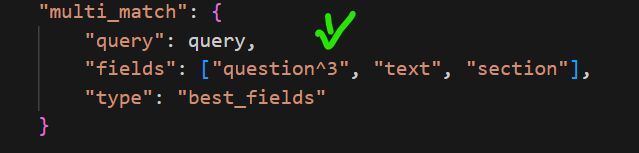

In [13]:
user_question = "How do I join the course after it has started?"

response = retrieve_documents(user_question)

for doc in response:
    print(f"Section: {doc['section']}\nQuestion: {doc['question']}\nAnswer: {doc['text']}\n\n")

Section: General course-related questions
Question: Course - Can I still join the course after the start date?
Answer: Yes, even if you don't register, you're still eligible to submit the homeworks.
Be aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.


Section: General course-related questions
Question: Course - Can I follow the course after it finishes?
Answer: Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.
You can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.


Section: General course-related questions
Question: Course - What can I do before the course starts?
Answer: You can start by installing and setting up all the dependencies and requirements:
Google cloud account
Google Cloud SDK
Python 3 (installed with Anaconda)
Terra

In [14]:
context = ""

for doc in response:
    doc_str = f"Section: {doc['section']}\nQuestion: {doc['question']}\nAnswer: {doc['text']}\n\n"
    context += doc_str

context = context.strip()
print(context)

Section: General course-related questions
Question: Course - Can I still join the course after the start date?
Answer: Yes, even if you don't register, you're still eligible to submit the homeworks.
Be aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.

Section: General course-related questions
Question: Course - Can I follow the course after it finishes?
Answer: Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.
You can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.

Section: General course-related questions
Question: Course - What can I do before the course starts?
Answer: You can start by installing and setting up all the dependencies and requirements:
Google cloud account
Google Cloud SDK
Python 3 (installed with Anaconda)
Terrafo

In [15]:
from dotenv import load_dotenv
import os

# Carga el archivo .env (por defecto busca en el mismo directorio)
load_dotenv()

# Recupera la variable de entorno
api_key = os.getenv("OPENAI_API_KEY")

# Prueba si se cargó correctamente
if api_key:
    print("✅ API key cargada correctamente")
else:
    print("❌ No se encontró la API key")

# (opcional) Mostrar el valor si estás haciendo pruebas locales
# print(f"La API key es: {api_key}")

✅ API key cargada correctamente


In [16]:
prompt = f"""
You're a course teaching assistant. Answer the user QUESTION based on CONTEXT - the documents retrieved from our FAQ database. 
Only use the facts from the CONTEXT. If the CONTEXT doesn't contan the answer, return "NONE"

QUESTION: {user_question}

CONTEXT:

{context}
""".strip()

In [17]:
prompt

'You\'re a course teaching assistant. Answer the user QUESTION based on CONTEXT - the documents retrieved from our FAQ database. \nOnly use the facts from the CONTEXT. If the CONTEXT doesn\'t contan the answer, return "NONE"\n\nQUESTION: How do I join the course after it has started?\n\nCONTEXT:\n\nSection: General course-related questions\nQuestion: Course - Can I still join the course after the start date?\nAnswer: Yes, even if you don\'t register, you\'re still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don\'t leave everything for the last minute.\n\nSection: General course-related questions\nQuestion: Course - Can I follow the course after it finishes?\nAnswer: Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start w

In [18]:
from openai import OpenAI

client = OpenAI()

In [19]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": prompt}]
)
response

ChatCompletion(id='chatcmpl-BhP6fhR9MjdlORMWKPKSjM9qypQqx', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="You can still join the course after it has started, and even if you don't register, you're still eligible to submit the homeworks. However, there will be deadlines for turning in the final projects.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1749684313, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens=42, prompt_tokens=620, total_tokens=662, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [20]:
answer = response.choices[0].message.content
print(answer)

You can still join the course after it has started, and even if you don't register, you're still eligible to submit the homeworks. However, there will be deadlines for turning in the final projects.


In [21]:
def build_context(documents):
    context = ""

    for doc in documents:
        doc_str = f"Section: {doc['section']}\nQuestion: {doc['question']}\nAnswer: {doc['text']}\n\n"
        context += doc_str
    
    context = context.strip()
    return context


def build_prompt(user_question, documents):
    context = build_context(documents)
    return f"""
You're a course teaching assistant.
Answer the user QUESTION based on CONTEXT - the documents retrieved from our FAQ database.
Don't use other information outside of the provided CONTEXT.  

QUESTION: {user_question}

CONTEXT:

{context}
""".strip()

In [22]:
def ask_openai(prompt, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}]
    )
    answer = response.choices[0].message.content
    return answer

In [23]:
def qa_bot(user_question):
    context_docs = retrieve_documents(user_question)
    prompt = build_prompt(user_question, context_docs)
    answer = ask_openai(prompt)
    return answer

In [27]:
qa_bot("I'm getting invalid reference format: repository name must be lowercase")

'To resolve the "invalid reference format: repository name must be lowercase" error in Docker, you can try replacing the "-v" part with one of the following options:\n- -v /c:/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data\n- -v //c:/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data\n- -v /c/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data\n- -v //c/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data\n- --volume //driveletter/path/ny_taxi_postgres_data/:/var/lib/postgresql/data\n\nTry adding quotes around the volume path, e.g.:\n- -v "/c:/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data"\n- -v "//c:/some/path/ny_taxi_postgres_data:/var/lib/postgresql/data"\n\nFor further information, you can check the following source: https://stackoverflow.com/questions/48522615/docker-error-invalid-reference-format-repository-name-must-be-lowercase'

In [25]:
qa_bot("I can't connect to postgres port 5432, my password doesn't work")

'To resolve the issue of not being able to connect to postgres port 5432 due to password authentication failure, you can try changing the port to 5431 or another available port that you mapped to when creating the docker container. Additionally, ensure that there is no local Postgres installation on your computer that might be causing conflicts with the connection. Consider checking for any running services on Windows related to Postgres and stopping them to potentially resolve the issue.'

In [29]:
qa_bot("how can I run kafka?")

'To run Kafka, you can use the Confluent Cloud and find the schema registry URL in the Stream Governance API section. Alternatively, you can create a virtual environment, install the necessary packages, and run the python file as required.\n\n'

In [28]:
qa_bot("Is kestra a valid orchestrator for the course?")

'Based on the information provided in the FAQ database, kestra is not mentioned as a valid orchestrator for the course. The course seems to focus on Docker and Terraform as mentioned in Module 1.'